<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs Similarity </h1>

### Problem Description
The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

### Real world/Business Objectives and Constraints 
We would want a probability of a pair of questions.<br>
Interpretability is partially important.

###  Data Overview 
id - the id of a training set question pair<br>
qid1, qid2 - unique ids of each question (only available in train.csv)<br>
question1, question2 - the full text of each question<br>
is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.<br>

### Type of ML problem 
It is a Classification problem,since is_duplicate is our target varaiable.
### Performance Metric 
Log-Loss<br>
Confusion Matrix

### NOTE : 
Most of Feature Engineering ideas are taken from some of the popular websites and platforms

In [74]:
#importing necessary libraries 
!pip install fuzzywuzzy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz

import warnings
warnings.filterwarnings("ignore")

# Reading data and basic stats 

In [75]:
df = pd.read_csv("quora_train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [76]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [78]:
#checking for Number of duplicate rows in a dataframe
df.duplicated().sum()

0

<AxesSubplot:>

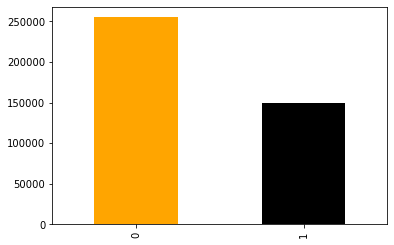

In [79]:
#distribution of target variable
c = ['orange', 'black','red', 'yellow', 'blue', 'orange']
df['is_duplicate'].value_counts().plot.bar(color=c)

In [80]:
#number of unique questions in data set
uniq_q1 = list(df['qid1'].unique())
uniq_q2 = list(df['qid2'].unique())
print("number of unique questions in data set : ",len(set(uniq_q1+uniq_q2)))

number of unique questions in data set :  537933


In [82]:
#number of occurrence of each question
uniq_ques = list(df['qid1'])+list(df['qid2'])
uniq_ques = pd.Series(uniq_ques)
uniq_ques.value_counts()

2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
416446      1
416444      1
416441      1
416439      1
537933      1
Length: 537933, dtype: int64

In [83]:
print("Maximum number of count a single question appeared ",uniq_ques.value_counts().max())
print("Minimum number of count a single question appeared ",uniq_ques.value_counts().min())

Maximum number of count a single question appeared  157
Minimum number of count a single question appeared  1


In [84]:
# Number of questions that appear only once and more than once
qs_e1 = np.sum(uniq_ques.value_counts()==1)
qs_g1 = np.sum(uniq_ques.value_counts()>1)

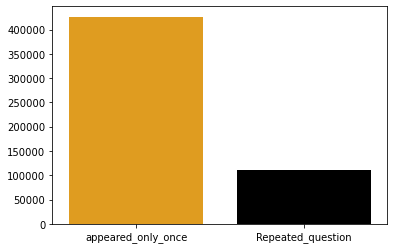

In [85]:
x = ['appeared_only_once','Repeated_question']
y = [qs_e1,qs_g1]
sns.barplot(x=x,y=y,palette=c)
plt.show()

# Basic Feature Extraction

- ____q1len____ = Length of q1
- ____q2len____ = Length of q2
- ____q1_n_words____ = Number of words in Question 1
- ____q2_n_words____ = Number of words in Question 2
- ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
- ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
- ____word_share____ = (word_common)/(word_Total)

In [86]:
df['q1len'] = df['question1'].apply(lambda x: len(str(x)))
df['q2len'] = df['question2'].apply(lambda x: len(str(x)))

In [87]:
df['q1_n_words'] = df['question1'].apply(lambda x: len(str(x).lower().split()))
df['q2_n_words'] = df['question2'].apply(lambda x: len(str(x).lower().split()))

In [88]:
def word_common(row):
    sen1 = set(map(lambda x: x.lower().strip(), str(row['question1']).split(" ")))
    sen2 = set(map(lambda x: x.lower().strip(), str(row['question2']).split(" ")))
    return 1.0 * len(sen1 & sen2)
df['word_Common'] = df.apply(word_common, axis=1)

In [89]:
def word_total(row):
    sen1 = list(map(lambda x: x.lower().strip(),str(row['question1']).split(" ")))
    sen2 = list(map(lambda x: x.lower().strip(),str(row['question2']).split(" ")))
    return 1.0*len(set(sen1+sen2))
df['wordtotal '] = df.apply(word_total,axis=1)

In [90]:
def wordshare(row):
    sen1 = list(map(lambda x: x.lower().strip(),str(row['question1']).split(" ")))
    sen2 = list(map(lambda x: x.lower().strip(),str(row['question2']).split(" ")))
    return 1.0 * (len(set(set(sen1)&set(sen2)))/len(sen1+sen2))
df['word_share'] = df.apply(wordshare,axis=1)

<AxesSubplot:xlabel='q1_n_words', ylabel='Density'>

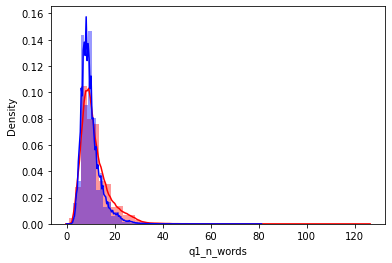

In [91]:
#univariate analysis for new features derived
sns.distplot(df[df['is_duplicate']==0]['q1_n_words'],color='red')
sns.distplot(df[df['is_duplicate']==1]['q1_n_words'],color='blue')

#### Since the distributions overlaps exactly on each other, this feature may not be that helpful in classifying the target variable.

<AxesSubplot:xlabel='word_share', ylabel='Density'>

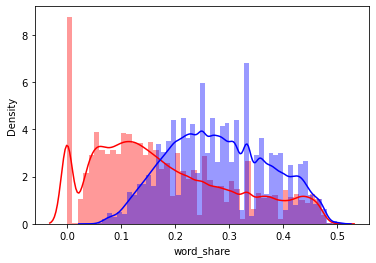

In [92]:
#univariate analysis for new features derived
sns.distplot(df[df['is_duplicate']==0]['word_share'],color='red')
sns.distplot(df[df['is_duplicate']==1]['word_share'],color='blue')

#### Since the distributions has some distinction, this feature surely add some importance in classifying the target variable.

In [132]:
import nltk
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Soorya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [94]:
#preprocessing the text features like removing angular braces, shortcuts, punctuation, special charaters etc..
def textpreprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace("(","").replace(")","").replace("?"," ").replace("<"," ").replace(">"," ")\
        .replace(","," ").replace("."," ").replace("$","dollars").replace("%","percent").replace("&"," ").replace("!","")\
        .replace("~","").replace("^"," ").replace("'ve"," have").replace("i'm","i am").replace("n't"," not")\
        .replace("'s"," is")
    porter = PorterStemmer()
    x = porter.stem(x)
    return x

# Feature Extraction (NLP and Fuzzy Features)

Features:
- __cwc_min__ :  common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>

In [95]:
def ctcmin(row):
    sen1 = set(map(lambda x: x.lower().strip(), str(row['question1']).split(" ")))
    sen2 = set(map(lambda x: x.lower().strip(), str(row['question2']).split(" ")))
    return 1.0 * (len(sen1&sen2)/(min(len(sen1),len(sen2))))
df['ctc_min'] = df.apply(ctcmin,axis=1)

In [96]:
def ctcmax(row):
    sen1 = set(map(lambda x: x.lower().strip(), str(row['question1']).split(" ")))
    sen2 = set(map(lambda x: x.lower().strip(), str(row['question2']).split(" ")))
    return 1.0 * (len(sen1&sen2)/(max(len(sen1),len(sen2))))
df['ctc_max'] = df.apply(ctcmax,axis=1)

In [97]:
SW = stopwords.words("english")
def cscmin(row):
    sen1 = set(map(lambda x: x if str(x).lower().strip() in SW else '', str(row['question1']).split(" ")))
    sen2 = set(map(lambda x: x if str(x).lower().strip() in SW else '', str(row['question2']).split(" ")))
    return 1.0 * (len(sen1&sen2)/(min(len(sen1),len(sen2))))
df['csc_min'] = df.apply(cscmin,axis=1)

In [98]:
def cscmax(row):
    sen1 = set(map(lambda x: x if str(x).lower().strip() in SW else '', str(row['question1']).split(" ")))
    sen2 = set(map(lambda x: x if str(x).lower().strip() in SW else '', str(row['question2']).split(" ")))
    return 1.0 * (len(sen1&sen2)/(max(len(sen1),len(sen2))))
df['csc_max'] = df.apply(cscmax,axis=1)

In [99]:
def cwcmin(row):
    sen1 = set(map(lambda x: x if str(x).lower().strip() not in SW else '', str(row['question1']).split(" ")))
    sen2 = set(map(lambda x: x if str(x).lower().strip() not in SW else '', str(row['question2']).split(" ")))
    return 1.0 * (len(sen1&sen2)/(min(len(sen1),len(sen2))))
df['cwc_min'] = df.apply(cscmin,axis=1)

def cwcmax(row):
    sen1 = set(map(lambda x: x if str(x).lower().strip() not in SW else '', str(row['question1']).split(" ")))
    sen2 = set(map(lambda x: x if str(x).lower().strip() not in SW else '', str(row['question2']).split(" ")))
    return 1.0 * (len(sen1&sen2)/(max(len(sen1),len(sen2))))
df['cwc_max'] = df.apply(cwcmax,axis=1)

In [100]:
# feature extractions using FuzzyWuzzy library
df["token_set_ratio"] = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)

In [101]:
df["token_sort_ratio"] = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)

In [102]:
df["fuzz_ratio"] = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)

<AxesSubplot:xlabel='token_sort_ratio', ylabel='Density'>

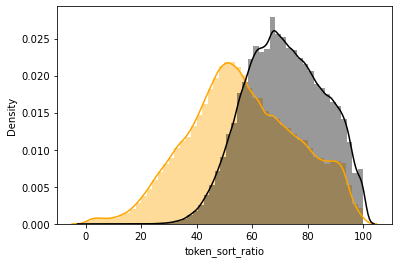

In [103]:
#univariate analysis for featured derived using fuzzywuzzy library 
sns.distplot(df[df['is_duplicate']==0]['token_sort_ratio'],label=0,color='orange')
sns.distplot(df[df['is_duplicate']==1]['token_sort_ratio'],label=1,color='black')

<AxesSubplot:xlabel='token_set_ratio', ylabel='Density'>

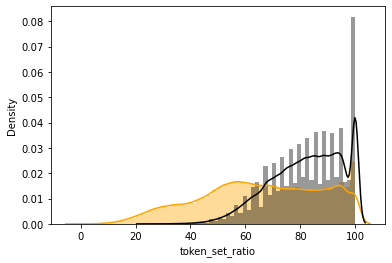

In [104]:
sns.distplot(df[df['is_duplicate']==0]['token_set_ratio'],label=0,color='orange')
sns.distplot(df[df['is_duplicate']==1]['token_set_ratio'],label=1,color='black')

#### simialarly since these distributions has some distinction, these feature surely add some importance in classifying the target variable.

In [106]:
#df["fuzz_partial_ratio"] = df.apply(lambda x: fuzz.partial_ratio(x['question1'] if type(x["question1"])==type('') else str(x['question1']),x['question2'] if type(x["question2"])==type('') else str(x['question2'])), axis=1)

In [107]:
df.to_csv("nlp_fuzzy_features_train.csv", index=False)

In [108]:
#I am choosing to work with only 1lakh rows, just to run code faster and learn efficiently
df = pd.read_csv("nlp_fuzzy_features_train.csv",nrows=100000)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,...,word_share,ctc_min,ctc_max,csc_min,csc_max,cwc_min,cwc_max,token_set_ratio,token_sort_ratio,fuzz_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,...,0.384615,0.909091,0.833333,1.00,1.0,1.00,0.714286,100,93,93
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,...,0.190476,0.500000,0.333333,0.75,0.6,0.75,0.300000,86,63,66


In [109]:
df.shape

(100000, 22)

# Featurizing text data with tfidf weighted word-vectors

In [110]:
#!pip install spacy
#!python -m spacy download en_core_web_lg
#!python -m spacy download en
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sys
import os 
import spacy

In [111]:
# merge texts
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer()
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [112]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_lg')

In [113]:
#to compute tf-idf weighted word2vec
vecs1 = []
for qu1 in list(df['question1']):
    doc1 = nlp(qu1)
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

In [114]:
#to compute tf-idf weighted word2vec
vecs2 = []
for qu2 in list(df['question2']):
    doc2 = nlp(qu2)
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

In [115]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,...,ctc_max,csc_min,csc_max,cwc_min,cwc_max,token_set_ratio,token_sort_ratio,fuzz_ratio,q1_feats_m,q2_feats_m
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,...,0.833333,1.00,1.0,1.00,0.714286,100,93,93,"[-10.490357637405396, 67.71664983034134, -252....","[0.06873679161071777, 74.17337363958359, -240...."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,...,0.333333,0.75,0.6,0.75,0.300000,86,63,66,"[-21.046945333480835, -19.72866916656494, 3.77...","[-87.43667221069336, 45.696125984191895, -100...."


In [116]:
df.shape

(100000, 24)

In [117]:
df = df.drop(['qid1','qid2','question1','question2'],axis=1)

In [118]:
df.shape

(100000, 20)

In [119]:
df_q1 = pd.DataFrame(df.q1_feats_m.values.tolist(), index= df.index)
df_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-10.490358,67.716650,-252.534138,-14.235931,161.223124,54.732753,-77.810293,159.519003,-242.635705,-2.605265,...,106.941576,-119.120608,-126.953811,84.698510,3.313622,28.512095,-27.564965,-162.025775,-133.192602,81.441715
1,-21.046945,-19.728669,3.778634,-49.334991,109.210123,-26.105859,51.461269,118.818088,4.199368,-19.403111,...,49.607121,12.188081,20.762028,20.201912,-20.092356,-15.767780,18.985266,-42.304387,-48.017733,4.490001
2,-56.948253,41.114509,-142.664478,71.136404,159.914929,-46.356194,39.587470,318.890618,-142.012595,78.135183,...,-30.816046,27.302098,25.596786,-47.278506,-94.666887,74.459630,57.274448,-192.683044,-203.266454,-19.852070
3,137.587500,76.044296,-73.108486,-161.251347,-82.579269,60.219514,4.645475,181.890980,-122.002410,34.779989,...,116.958943,-126.398069,31.782153,-103.741168,-25.959739,-72.113089,69.932266,67.691687,-174.070326,210.949989
4,14.930954,-117.498493,-209.319653,41.312727,151.538341,-231.843793,-10.770989,333.096592,163.335007,-76.167248,...,47.964490,-105.505096,267.372394,-84.933539,-252.837682,135.269930,348.701591,13.498664,50.351975,-64.068006


In [120]:
df_q1.shape

(100000, 300)

In [121]:
df_q2 = pd.DataFrame(df.q2_feats_m.values.tolist(), index= df.index)
df_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.068737,74.173374,-240.776133,-19.862189,117.439652,65.336051,-82.578378,136.546768,-268.090901,7.628024,...,84.086659,-102.946840,-119.868758,94.617919,25.614550,-3.162477,-23.255782,-130.485935,-122.642702,83.619830
1,-87.436672,45.696126,-100.979003,-16.830744,82.651195,57.025187,23.570928,171.827352,63.619083,17.874090,...,39.964335,47.398391,68.536555,64.871188,-72.029023,55.944378,-106.100173,67.257869,-83.172969,56.257194
2,-68.923405,-25.181076,-143.850184,94.621917,48.743341,-36.890199,3.669353,213.575387,-80.767843,-10.921903,...,69.113829,-16.305392,26.457790,51.437134,-63.676421,115.731224,78.842699,-191.133551,-48.844331,146.335136
3,-177.371868,-38.649545,-71.636115,-14.928945,161.150551,-14.427077,13.613269,97.053000,-4.039911,-63.407115,...,54.338028,-38.409576,-42.333814,35.973171,-68.818702,85.952606,-17.397774,-152.899816,4.734504,64.022601
4,1.201464,8.112584,-120.100698,24.159073,83.461844,-80.789498,-42.664855,178.750775,-40.341752,54.407175,...,96.951311,-58.741223,93.236875,-69.277219,-140.277700,-70.023601,5.089724,-31.030534,-24.409899,3.358120


In [122]:
df_q2.shape

(100000, 300)

In [123]:
#Finally after merging all the dataframe we will operate with 619 features/dimensions
df_q1['id']=df['id']
df_q2['id']=df['id']
df_inter = df_q1.merge(df_q2, on='id',how='left')
df_inter.shape

(100000, 601)

In [124]:
df_inter.head()

,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,-10.490358,67.716650,-252.534138,-14.235931,161.223124,54.732753,-77.810293,159.519003,-242.635705,-2.605265,...,84.086659,-102.946840,-119.868758,94.617919,25.614550,-3.162477,-23.255782,-130.485935,-122.642702,83.619830
1,-21.046945,-19.728669,3.778634,-49.334991,109.210123,-26.105859,51.461269,118.818088,4.199368,-19.403111,...,39.964335,47.398391,68.536555,64.871188,-72.029023,55.944378,-106.100173,67.257869,-83.172969,56.257194
2,-56.948253,41.114509,-142.664478,71.136404,159.914929,-46.356194,39.587470,318.890618,-142.012595,78.135183,...,69.113829,-16.305392,26.457790,51.437134,-63.676421,115.731224,78.842699,-191.133551,-48.844331,146.335136
3,137.587500,76.044296,-73.108486,-161.251347,-82.579269,60.219514,4.645475,181.890980,-122.002410,34.779989,...,54.338028,-38.409576,-42.333814,35.973171,-68.818702,85.952606,-17.397774,-152.899816,4.734504,64.022601
4,14.930954,-117.498493,-209.319653,41.312727,151.538341,-231.843793,-10.770989,333.096592,163.335007,-76.167248,...,96.951311,-58.741223,93.236875,-69.277219,-140.277700,-70.023601,5.089724,-31.030534,-24.409899,3.358120


In [128]:
df_final = df.merge(df_inter,on='id',how='left')
df_final.shape

(100000, 620)

In [129]:
df_final.head()

,id,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Common,wordtotal,word_share,ctc_min,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,66,57,14,12,10.0,13.0,0.384615,0.909091,...,84.086659,-102.946840,-119.868758,94.617919,25.614550,-3.162477,-23.255782,-130.485935,-122.642702,83.619830
1,1,0,51,88,8,13,4.0,16.0,0.190476,0.500000,...,39.964335,47.398391,68.536555,64.871188,-72.029023,55.944378,-106.100173,67.257869,-83.172969,56.257194
2,2,0,73,59,14,10,4.0,20.0,0.166667,0.400000,...,69.113829,-16.305392,26.457790,51.437134,-63.676421,115.731224,78.842699,-191.133551,-48.844331,146.335136
3,3,0,50,65,11,9,0.0,19.0,0.000000,0.000000,...,54.338028,-38.409576,-42.333814,35.973171,-68.818702,85.952606,-17.397774,-152.899816,4.734504,64.022601
4,4,0,76,39,13,7,2.0,18.0,0.100000,0.285714,...,96.951311,-58.741223,93.236875,-69.277219,-140.277700,-70.023601,5.089724,-31.030534,-24.409899,3.358120


In [131]:
#df_final.to_csv("final_features_quora_train.csv", index=False)

In [140]:
df = pd.read_csv("final_features_quora_train.csv")
df.head()

,id,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,word_Common,wordtotal,word_share,ctc_min,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,66,57,14,12,10.0,13.0,0.384615,0.909091,...,84.086659,-102.946840,-119.868758,94.617919,25.614550,-3.162477,-23.255782,-130.485935,-122.642702,83.619830
1,1,0,51,88,8,13,4.0,16.0,0.190476,0.500000,...,39.964335,47.398391,68.536555,64.871188,-72.029023,55.944378,-106.100173,67.257869,-83.172969,56.257194
2,2,0,73,59,14,10,4.0,20.0,0.166667,0.400000,...,69.113829,-16.305392,26.457790,51.437134,-63.676421,115.731224,78.842699,-191.133551,-48.844331,146.335136
3,3,0,50,65,11,9,0.0,19.0,0.000000,0.000000,...,54.338028,-38.409576,-42.333814,35.973171,-68.818702,85.952606,-17.397774,-152.899816,4.734504,64.022601
4,4,0,76,39,13,7,2.0,18.0,0.100000,0.285714,...,96.951311,-58.741223,93.236875,-69.277219,-140.277700,-70.023601,5.089724,-31.030534,-24.409899,3.358120


In [141]:
df.shape

(100000, 620)

In [145]:
df.isnull().sum().sum()

0

In [146]:
df.drop('id',axis=1,inplace=True)

# Building model on these derived features

In [218]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibratedClassifierCV

from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

In [226]:
df.drop('q2_feats_m',axis=1,inplace=True)
df.drop('q1_feats_m',axis=1,inplace=True)

x = df.drop('is_duplicate',axis=1)
y = df['is_duplicate']

In [227]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [228]:
print("distribution of target variable in train and test dataset")
print("*"*10,"Train dataset","*"*10)
print("0's percentage: ",str((y_train.value_counts()[0])/80000))
print("1's percentage: ",str((y_train.value_counts()[1])/80000))
print("*"*10,"Test dataset","*"*10)
print("0's percentage: ",str((y_test.value_counts()[0])/20000))
print("1's percentage: ",str((y_test.value_counts()[1])/20000))

distribution of target variable in train and test dataset
********** Train dataset **********
0's percentage:  0.628625
1's percentage:  0.371375
********** Test dataset **********
0's percentage:  0.6228
1's percentage:  0.3772


In [229]:
# again splitting the train dataset for cross validation
x_train, x_cv, y_train, y_cv = train_test_split(x_train,y_train,test_size=0.2,random_state=42)

## Building a RANDOM MODEL

In [230]:
# Building a random model, so as to compare with complex models we build as we are using the log loss as a parameter
# and it can vary between 0 to infinity.
test_len = len(y_test)
predicted_y = np.zeros((test_len,2))
pred_y = np.zeros(test_len)
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
    pred_y[i] = np.argmax(predicted_y[i])
print("Log loss on Test Data using Random Model : ",log_loss(y_test, predicted_y))

Log loss on Test Data using Random Model :  0.8855522540118133


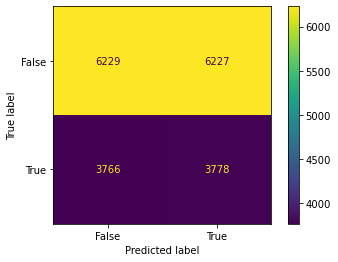

In [231]:
confusion_matrix = metrics.confusion_matrix(y_test, pred_y)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

### Since we are dealing with a bit large dimensional data linear models tend to work well.
#### So i am trying with logistic regression, SVM, RandomForestClassifier.

In [248]:
opt_c = [10**x for x in range(-5,5)]
logloss = []

for x in opt_c:
    lr = LogisticRegression(C = x)
    lr.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(lr, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_cv)
    logloss.append(log_loss(y_cv, predict_y, eps=1e-15))
    print('For values of alpha = ', x, "The log loss is:",log_loss(y_cv, predict_y, labels=lr.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.5430081024914497
For values of alpha =  0.0001 The log loss is: 0.5435362943988513
For values of alpha =  0.001 The log loss is: 0.543336080400045
For values of alpha =  0.01 The log loss is: 0.5430284699025463
For values of alpha =  0.1 The log loss is: 0.5428679100608654
For values of alpha =  1 The log loss is: 0.5431287417385843
For values of alpha =  10 The log loss is: 0.5430985902734065
For values of alpha =  100 The log loss is: 0.542518201238848
For values of alpha =  1000 The log loss is: 0.5426095964318098
For values of alpha =  10000 The log loss is: 0.5424016735787622


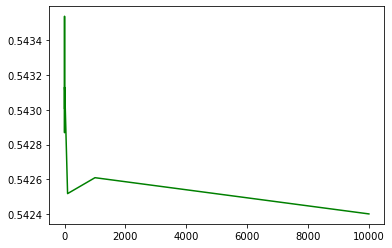

LOG-LOSS IS LEAST AT : 10000


In [250]:
plt.plot(opt_c, logloss,c='g')
plt.show()
print("LOG-LOSS IS LEAST AT :",opt_c[logloss.index(min(logloss))])

In [251]:
print("**************** Training the model at optimal value of C ****************")
lr = LogisticRegression(C = 10000)
lr.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(lr, method="sigmoid")
sig_clf.fit(x_train, y_train)
predict_y = sig_clf.predict_proba(x_test)
print("Log loss on test data after training on optimal c/lambda value : ",log_loss(y_test, predict_y, eps=1e-15))

**************** Training the model at optimal value of C ****************
Log loss on test data after training on optimal c/lambda value :  0.5433613329798249


In [252]:
predict_y

array([[0.35445822, 0.64554178],
       [0.68800917, 0.31199083],
       [0.4206551 , 0.5793449 ],
       ...,
       [0.69979586, 0.30020414],
       [0.25960076, 0.74039924],
       [0.92059556, 0.07940444]])

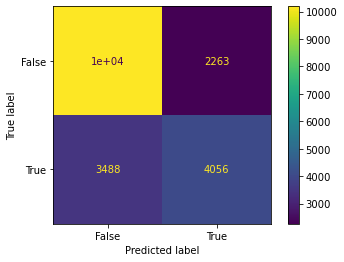

In [253]:
pred_y = np.zeros(test_len)
for i in range(test_len):
    pred_y[i] = np.argmax(predict_y[i])
confusion_matrix = metrics.confusion_matrix(y_test, pred_y)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [259]:
# Training Random Forest model
n_est = [100, 200, 400, 600]
logloss = []

for x in n_est:
    rfc = RandomForestClassifier(n_estimators = x, random_state=0,n_jobs = -1)
    rfc.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(rfc, method="sigmoid",n_jobs = -1)
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_cv)
    logloss.append(log_loss(y_cv, predict_y, eps=1e-15))
    print('For values of alpha = ', x, "The log loss is:",log_loss(y_cv, predict_y, labels=rfc.classes_, eps=1e-15))

For values of alpha =  100 The log loss is: 0.4154251468908977
For values of alpha =  200 The log loss is: 0.4126033921987109
For values of alpha =  400 The log loss is: 0.41186146312573896
For values of alpha =  600 The log loss is: 0.4112648737552015


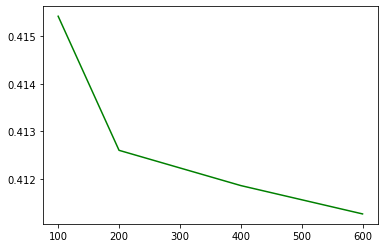

LOG-LOSS IS LEAST AT estimator number : 600


In [260]:
plt.plot(n_est, logloss,c='g')
plt.show()
print("LOG-LOSS IS LEAST AT estimator number :",n_est[logloss.index(min(logloss))])

In [261]:
print("**************** Training the model at optimal value of n_estimators ****************")
sig_clf = CalibratedClassifierCV(rfc, method="sigmoid")
sig_clf.fit(x_train, y_train)
predict_y = sig_clf.predict_proba(x_test)
print("Log loss on test data after training on optimal c/lambda value : ",log_loss(y_test, predict_y, eps=1e-15))

**************** Training the model at optimal value of n_estimators ****************
Log loss on test data after training on optimal c/lambda value :  0.4183606801787103


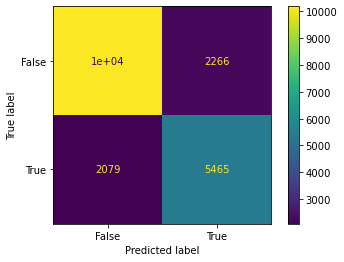

In [262]:
pred_y = np.zeros(test_len)
for i in range(test_len):
    pred_y[i] = np.argmax(predict_y[i])
confusion_matrix = metrics.confusion_matrix(y_test, pred_y)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

#### We can conclude this is better compared to both random model and logistic regression model in terms of both log-loss and confusion matrix as number of correctly classified points are increased and probability score also have increased.